<a href="https://colab.research.google.com/github/gokmenkilic/ML-Intro/blob/gk%2Ftests/Fusion_Plasma_Clustering_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Plasma Clustering​

In this notebook, we attempt to cluster time series data using a convolutional Long short-term memory (LSTM) model.

Thomson scattering is an important tool for plasma diagnostics in nuclear fusion facilities. Thomson Scattering data mapping the electron temperature and density of the profiles are clubbed into 5 groups using our clustering pipeline. The data initially passes through a convolutional LSTM, before PCA which is followed by Mean Shift and Agglomerative Clustering.

In [2]:
# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Activation, LSTM, Input
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Flatten, Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras import layers
from tensorflow.keras.layers import RepeatVector

# check version
print('Using TensorFlow v%s' % tf.__version__)
acc_str = 'accuracy' if tf.__version__[:2] == '2.' else 'acc'


# helpers
import urllib.request
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from collections import Counter
from numpy import asarray as ar,exp
from sklearn.model_selection import train_test_split
from sklearn import mixture
from sklearn import cluster
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.patches as mpatches
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MeanShift
import os
from IPython.display import clear_output
import h5py
from os.path import join


# need some certainty in data processing
np.random.seed(1234)
tf.random.set_seed(1234)

Using TensorFlow v2.19.0


## Data Setup & Google Colab Environment

The dataset is hosted publicly by DiRAC on COSMA. **Please make sure you run the cell below to download the data.**

To access the data from COSMA, you need to:

1. Run the first cell;
2. It will create a folder called sciml-workshop-data.
3. It will download the necessary HDF5 files directly into that folder.
4. Run the second cell and wait until the data folder appears.

If everything works correctly, a new folder called `sciml-workshop-data` should appear in the file browser on the left. Depending on the network speed, this may take one or two minutes. Ignore the warning "You do not appear to have access to project ...". If you are running the notebook locally or you have already connected to the bucket, these cells will have no side effects.

In [3]:
# data setup configuration
data_path = 'sciml-workshop-data'
full_dir = os.path.join(data_path, 'Fusion')
os.makedirs(full_dir, exist_ok=True)

base_url = "https://virgodb.cosma.dur.ac.uk/public/dc-kili1/sciml-workshop-data/Fusion/"
files_to_download = ["fusion_targets.h5"]

In [4]:
for filename in files_to_download:
    path = os.path.join(full_dir, filename)

    if not os.path.exists(path):
        urllib.request.urlretrieve(base_url + filename, path)

# 1. Load the dataset

### Read in the Thomson scattering data

Use pandas to read the hdf 'Fusion/fusion_targets.h5'. 'fusion_targets.h5' includes electron density and electron temperature. All time series follow the same times and shot number.

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
with h5py.File(join(data_path, 'Fusion/fusion_targets.h5'), 'r') as F:

    shot_num = {}
    for i in range(len(np.array(F['shot_num']))):
        shot_num[i] = int(np.array(F['shot_num'][str(i)]))
        
    time_data = {}
    for i in range(len(np.array(F['time_data']))):
        time_data[i] = np.array(F['time_data'][str(i)])
    
    density_data = {}
    for i in range(len(np.array(F['density_data']))):
        density_data[i] = np.array(F['density_data'][str(i)])
    
    temperature_data = {}
    for i in range(len(np.array(F['temperature_data']))):
        temperature_data[i] = np.array(F['temperature_data'][str(i)])
```
    
</p>
</details>


In [5]:
with h5py.File(join(data_path, 'Fusion/fusion_targets.h5'), 'r') as F:

    shot_num = {}
    for i in range(len(np.array(F['shot_num']))):
        shot_num[i] = int(np.array(F['shot_num'][str(i)]))

    time_data = {}
    for i in range(len(np.array(F['time_data']))):
        time_data[i] = np.array(F['time_data'][str(i)])

    density_data = {}
    for i in range(len(np.array(F['density_data']))):
        density_data[i] = np.array(F['density_data'][str(i)])

    temperature_data = {}
    for i in range(len(np.array(F['temperature_data']))):
        temperature_data[i] = np.array(F['temperature_data'][str(i)])

In [6]:
## how many instances are measurements taken at per shot
shot_length = []
for i in range(len(time_data)):
    shot_length.append(len(time_data[i]))

max_shot_length = np.max(shot_length)
print(max_shot_length)

151


In [7]:
e_temp = temperature_data
e_density = density_data
shot_num = shot_num

### Add rows of zeros to each shot to equalise the dimensions based on the longest shot length

In [8]:
for i in range(len(shot_num)):
    extra_rows = np.zeros((max_shot_length-len(e_temp[i]),110))
    e_temp[i] = np.concatenate((e_temp[i],extra_rows),axis=0)
    e_density[i] = np.concatenate((e_density[i],extra_rows),axis=0)

clear_output()

### Turn list of 2D arrays into 3D array

In [9]:
e_density = np.stack(list(e_density.values()))
e_temp = np.stack(list(e_temp.values()))
print(np.shape(e_density))
print(np.shape(e_temp))

(1366, 151, 110)
(1366, 151, 110)


### Plot electron density and temperature profile for each time

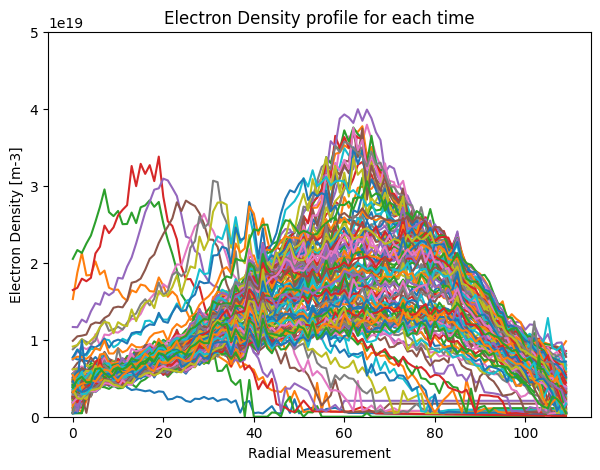

In [10]:
# density
shot_index = 500
fig = plt.figure(figsize=(7,5))
for ii in range(len(time_data[shot_index])):
    plt.plot(e_density[shot_index][ii])
    plt.ylim(0, 0.5*1e20)
    plt.title('Electron Density profile for each time')
    plt.xlabel('Radial Measurement')
    plt.ylabel('Electron Density [m-3]')


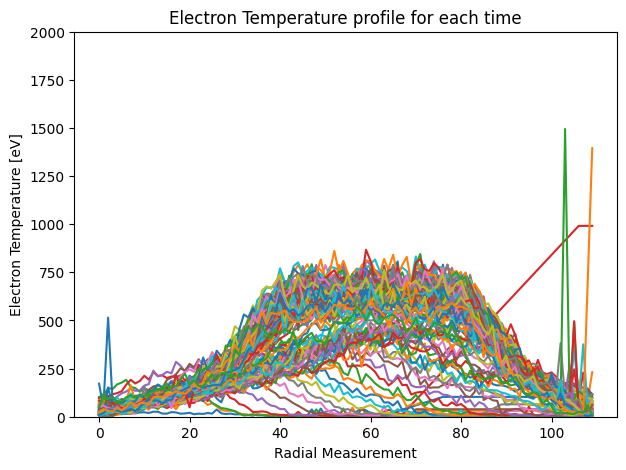

In [11]:
# temperature
shot_index = 500
fig = plt.figure(figsize=(7,5))
for ii in range(len(time_data[shot_index])):
    plt.plot(e_temp[shot_index][ii])
    plt.ylim(0, 2000)
    plt.title('Electron Temperature profile for each time')
    plt.xlabel('Radial Measurement')
    plt.ylabel('Electron Temperature [eV]')


### Visualize an example of time vs radius image of electron temperature and density

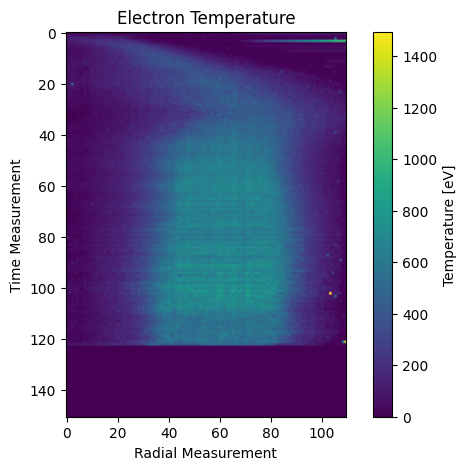

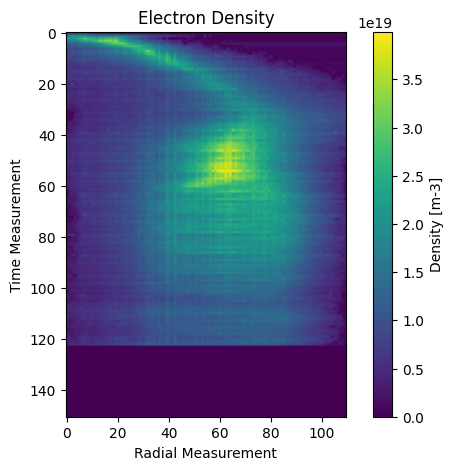

In [12]:
# time vs. radius
shot_index = 500

plt.figure(figsize=(7,5))
plt.imshow(e_temp[shot_index])
plt.title('Electron Temperature')
plt.xlabel('Radial Measurement')
plt.ylabel('Time Measurement')
plt.colorbar(label='Temperature [eV]')

plt.figure(figsize=(7,5))
plt.imshow(e_density[shot_index])
plt.title('Electron Density')
plt.xlabel('Radial Measurement')
plt.ylabel('Time Measurement')
plt.colorbar(label='Density [m-3]')

# 2. Build the network

### Dimensionality reduction via autoencoder and PCA

In [13]:
## prepare temperature and density arrays for Convolutional LSTM Autoencoder

new_e_temp = np.reshape(e_temp,(len(e_temp),1,151,110,1))
new_e_density = np.reshape(e_density,(len(e_density),1,151,110,1))

## normalise data

new_e_temp = new_e_temp/np.max(new_e_temp)
new_e_density = new_e_density/np.max(new_e_density)

print(new_e_temp.shape)
print(new_e_density.shape)

(1366, 1, 151, 110, 1)
(1366, 1, 151, 110, 1)


### Combine temp and density into one array

In [14]:
new_e_all = np.concatenate([new_e_temp,new_e_density],axis=4)
np.shape(new_e_all)

(1366, 1, 151, 110, 2)

### Set up the Convolutional LSTM Autoencoder for dimensionality reduction

Convolutional LSTM takes temp and density as an input. Hence the input shape should be 1$\times$151$\times$110$\times$2.

In [15]:
# this is our input placeholder
input_img = Input(shape=(1,151,110,2))
x = layers.ConvLSTM2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = Reshape((151,110,16))(x)
x = Dropout(0.2)(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(4, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(4, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

x = TimeDistributed(Flatten())(encoded)
x = Reshape((-1, 80))(x)

x = LSTM(228, activation='relu', return_sequences=True, stateful=False)(x)
x = Dropout(0.2)(x)
x = LSTM(784, activation='relu', return_sequences=True, stateful=False)(x)
x = Dense(7840, activation='relu')(x)
x = Dropout(0.2)(x)
#x = Dense(16610, activation='relu')(x)
#x = Dropout(0.2)(x)
x = Dense(33220, activation='relu')(x)
decoded = Reshape((1,151,110,2))(x)

autoencoder = keras.Model(input_img, decoded)

encoder = keras.Model(input_img, encoded)
print(autoencoder.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1, 151, 110, 2) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d (ConvLSTM2D)        │ (None, 151, 110, 16)   │        10,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 151, 110, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 151, 110, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 76, 55, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 76, 55, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 28, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 38, 28, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 19, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 19, 14, 4)      │           292 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 7, 4)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 7, 4)       │           148 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 4, 4)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 5, 16)          │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 1, 80)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 1, 228)         │       281,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 228)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 784)         │     3,176,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1, 7840)        │     6,154,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 7840)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1, 33220)       │   260,478,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 1, 151, 110, 2) │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 270,103,612 (1.01 GB)

 Trainable params: 270,103,612 (1.01 GB)

 Non-trainable params: 0 (0.00 B)

None


### Compile and train the model

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# e_all
x_data = new_e_all

# run the autoencoder
history = autoencoder.fit(x_data, x_data,
                epochs=50,
                batch_size=64,
                shuffle=True,
                validation_split=1/12.)
```
    
</p>
</details>

In [16]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# e_all
x_data = new_e_all

# run the autoencoder
history = autoencoder.fit(x_data, x_data,
                epochs=50,
                batch_size=64,
                shuffle=True,
                validation_split=1/12.)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - loss: 0.0954 - val_loss: 0.0765
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 384ms/step - loss: 0.0670 - val_loss: 0.0743
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 385ms/step - loss: 0.0651 - val_loss: 0.0737
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 388ms/step - loss: 0.0646 - val_loss: 0.0732
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 387ms/step - loss: 0.0641 - val_loss: 0.0730
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 394ms/step - loss: 0.0639 - val_loss: 0.0726
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 399ms/step - loss: 0.0630 - val_loss: 0.0714
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 398ms/step - loss: 0.0614 - val_loss: 0.0705
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 400ms/step - loss: 0.0606 - val_loss: 0.0702
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 403ms/step - loss: 0.0602 - val_loss: 0.0697
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 403ms/step - loss: 0.0600 - val_loss: 0.0695
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 404ms/step -

---

# 3. Analyse results

### Obtain encodings using the encoder

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
# encode the data
encoded_imgs = encoder.predict(x_data)
encoded_imgs = encoded_imgs.reshape(len(encoded_imgs),-1)
print(encoded_imgs.shape)
```
    
</p>
</details>

In [17]:
# encode the data
encoded_imgs = encoder.predict(x_data)
encoded_imgs = encoded_imgs.reshape(len(encoded_imgs),-1)
print(encoded_imgs.shape)

43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step
(1366, 80)


### Check training history

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
# loss curves
plt.figure(figsize=(9,6))
plt.plot(history.history['loss'],linewidth=2.5)
plt.plot(history.history['val_loss'],linewidth=2.5)
plt.ylabel('Loss value',fontsize=14)
plt.xlabel('Epoch',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['Training loss', 'Validation loss'], loc='upper right',fontsize=14)
plt.show()
```
    
</p>
</details>

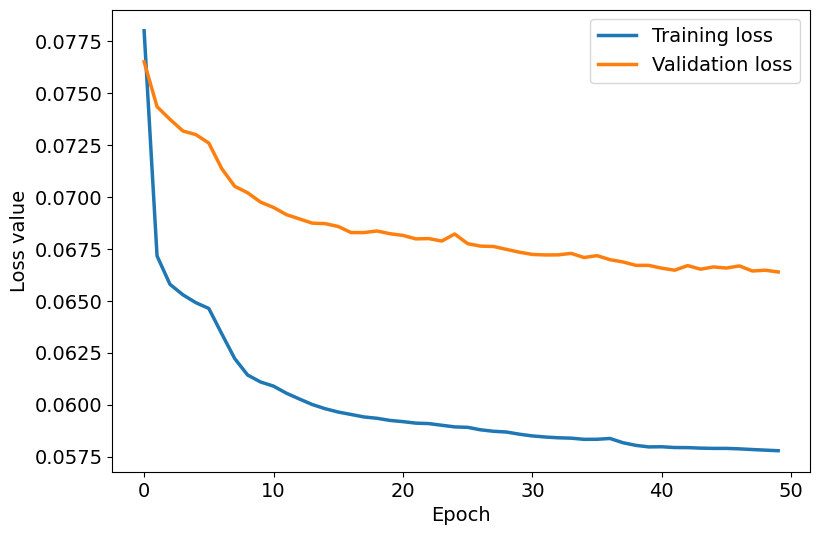

In [18]:
# loss curves
plt.figure(figsize=(9,6))
plt.plot(history.history['loss'],linewidth=2.5)
plt.plot(history.history['val_loss'],linewidth=2.5)
plt.ylabel('Loss value',fontsize=14)
plt.xlabel('Epoch',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['Training loss', 'Validation loss'], loc='upper right',fontsize=14)
plt.show()

### Reduce the dimensionality of the encoded data to 2 using PCA

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
model_encoder = PCA(n_components=2)
encoded_imgs_2d = model_encoder.fit_transform(encoded_imgs)
print(encoded_imgs_2d.shape)
```
    
</p>
</details>

In [19]:
model_encoder = PCA(n_components=2)
encoded_imgs_2d = model_encoder.fit_transform(encoded_imgs)
print(encoded_imgs_2d.shape)

(1366, 2)


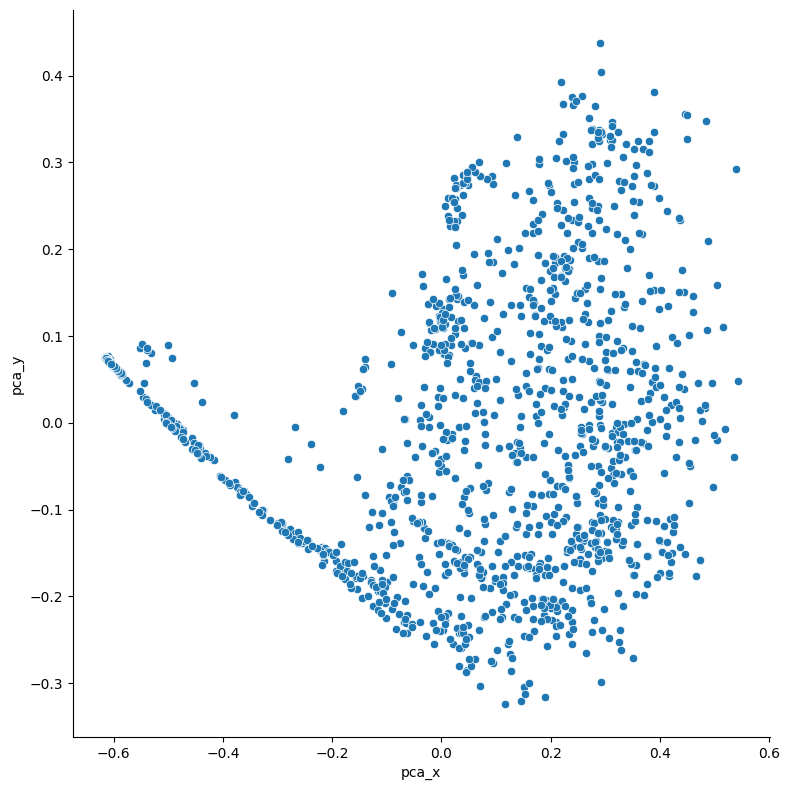

In [20]:
df_pca = pd.DataFrame({'pca_x':encoded_imgs_2d[:,0], 'pca_y':encoded_imgs_2d[:,1]})
sns.pairplot(x_vars=['pca_x'], y_vars=['pca_y'], data=df_pca, height=8)
sns.set(style="whitegrid")

### reduce the dimensionality of the encoded data to 3using PCA

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
model_encoder = PCA(n_components=3)
encoded_imgs_3d = model_encoder.fit_transform(encoded_imgs)
```
    
</p>
</details>

In [21]:
model_encoder = PCA(n_components=3)
encoded_imgs_3d = model_encoder.fit_transform(encoded_imgs)

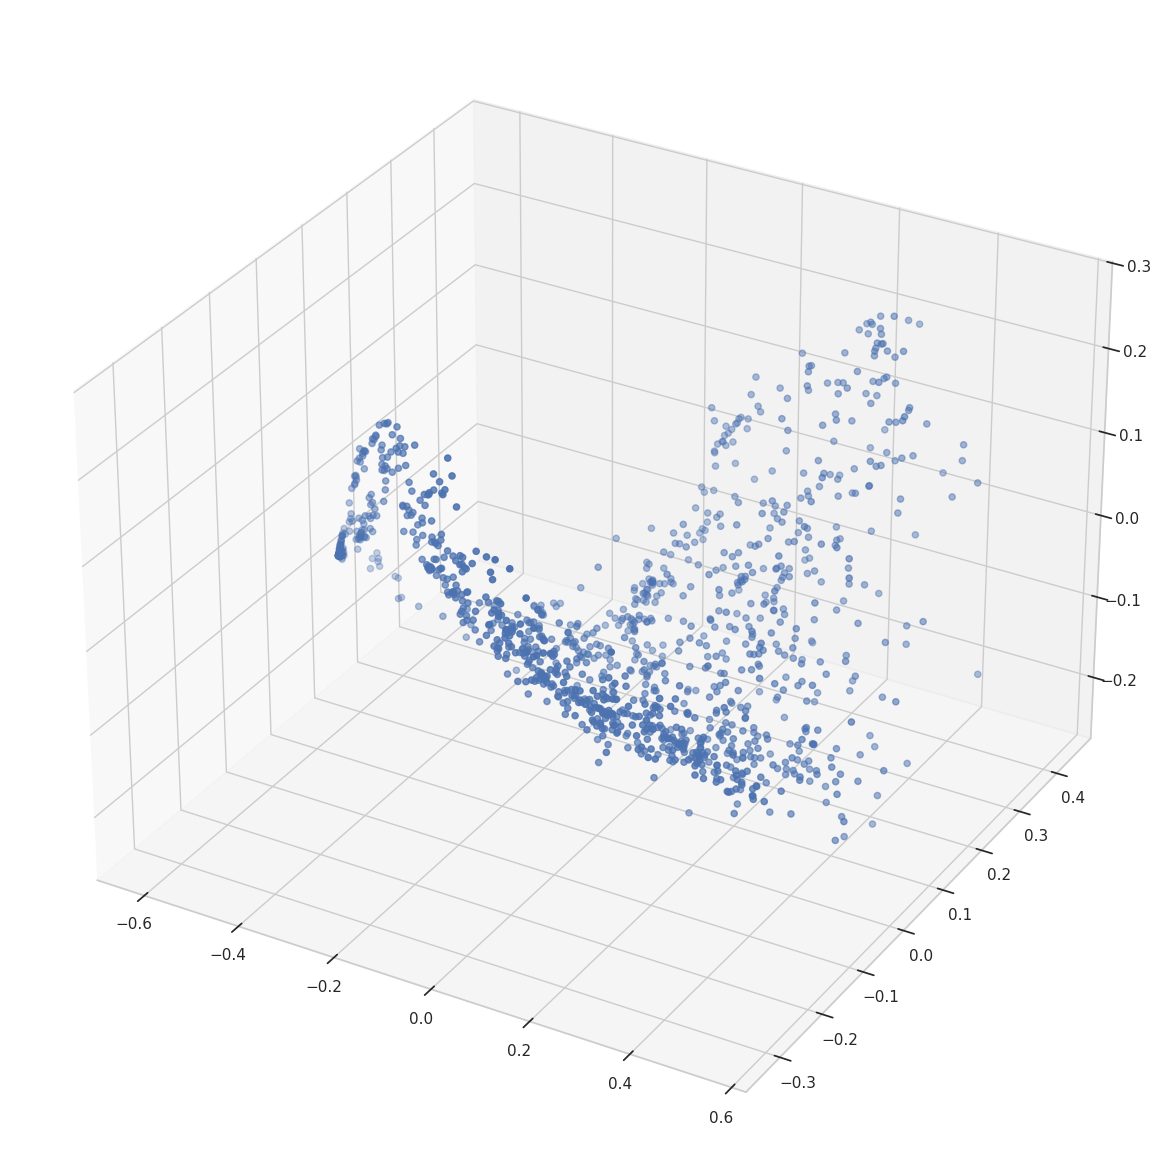

In [22]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(encoded_imgs_3d[:,0],encoded_imgs_3d[:,1],encoded_imgs_3d[:,2])

### reduce the dimensionality of the encoded data to 9 using PCA

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
model_encoder_9 = PCA(n_components=9)
encoded_imgs_9d = model_encoder_9.fit_transform(encoded_imgs)
```
    
</p>
</details>

In [23]:
model_encoder_9 = PCA(n_components=9)
encoded_imgs_9d = model_encoder_9.fit_transform(encoded_imgs)

### Cluster encoded_imgs_9d using AgglomerativeClustering method

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
ac_clustering_9 = AgglomerativeClustering(n_clusters=5,linkage='ward').fit(encoded_imgs_9d)

ac_clustering_9 = ac_clustering_9.labels_
```
    
</p>
</details>

In [24]:
ac_clustering_9 = AgglomerativeClustering(n_clusters=5,linkage='ward').fit(encoded_imgs_9d)

ac_clustering_9 = ac_clustering_9.labels_

In [25]:
# define a colour palette for clustering plot

palette=['steelblue','darkorange','forestgreen','firebrick','purple','sienna','palevioletred','grey']

### Devide encoded_imag encoded_imgs_3d with respect to their corresponding ac_clustering_9 label

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
## show the 9D clustering results in 3D space

encoded_imgs_3d_0 = []
encoded_imgs_3d_1 = []
encoded_imgs_3d_2 = []
encoded_imgs_3d_3 = []
encoded_imgs_3d_4 = []

for i in range(len(ac_clustering_9)):
    if ac_clustering_9[i] == 0:
        encoded_imgs_3d_0.append(encoded_imgs_3d[i])
    if ac_clustering_9[i] == 1:
        encoded_imgs_3d_1.append(encoded_imgs_3d[i])
    if ac_clustering_9[i] == 2:
        encoded_imgs_3d_2.append(encoded_imgs_3d[i])
    if ac_clustering_9[i] == 3:
        encoded_imgs_3d_3.append(encoded_imgs_3d[i])
    if ac_clustering_9[i] == 4:
        encoded_imgs_3d_4.append(encoded_imgs_3d[i])
```
    
</p>
</details>

In [26]:
## show the 9D clustering results in 3D space

encoded_imgs_3d_0 = []
encoded_imgs_3d_1 = []
encoded_imgs_3d_2 = []
encoded_imgs_3d_3 = []
encoded_imgs_3d_4 = []

for i in range(len(ac_clustering_9)):
    if ac_clustering_9[i] == 0:
        encoded_imgs_3d_0.append(encoded_imgs_3d[i])
    if ac_clustering_9[i] == 1:
        encoded_imgs_3d_1.append(encoded_imgs_3d[i])
    if ac_clustering_9[i] == 2:
        encoded_imgs_3d_2.append(encoded_imgs_3d[i])
    if ac_clustering_9[i] == 3:
        encoded_imgs_3d_3.append(encoded_imgs_3d[i])
    if ac_clustering_9[i] == 4:
        encoded_imgs_3d_4.append(encoded_imgs_3d[i])

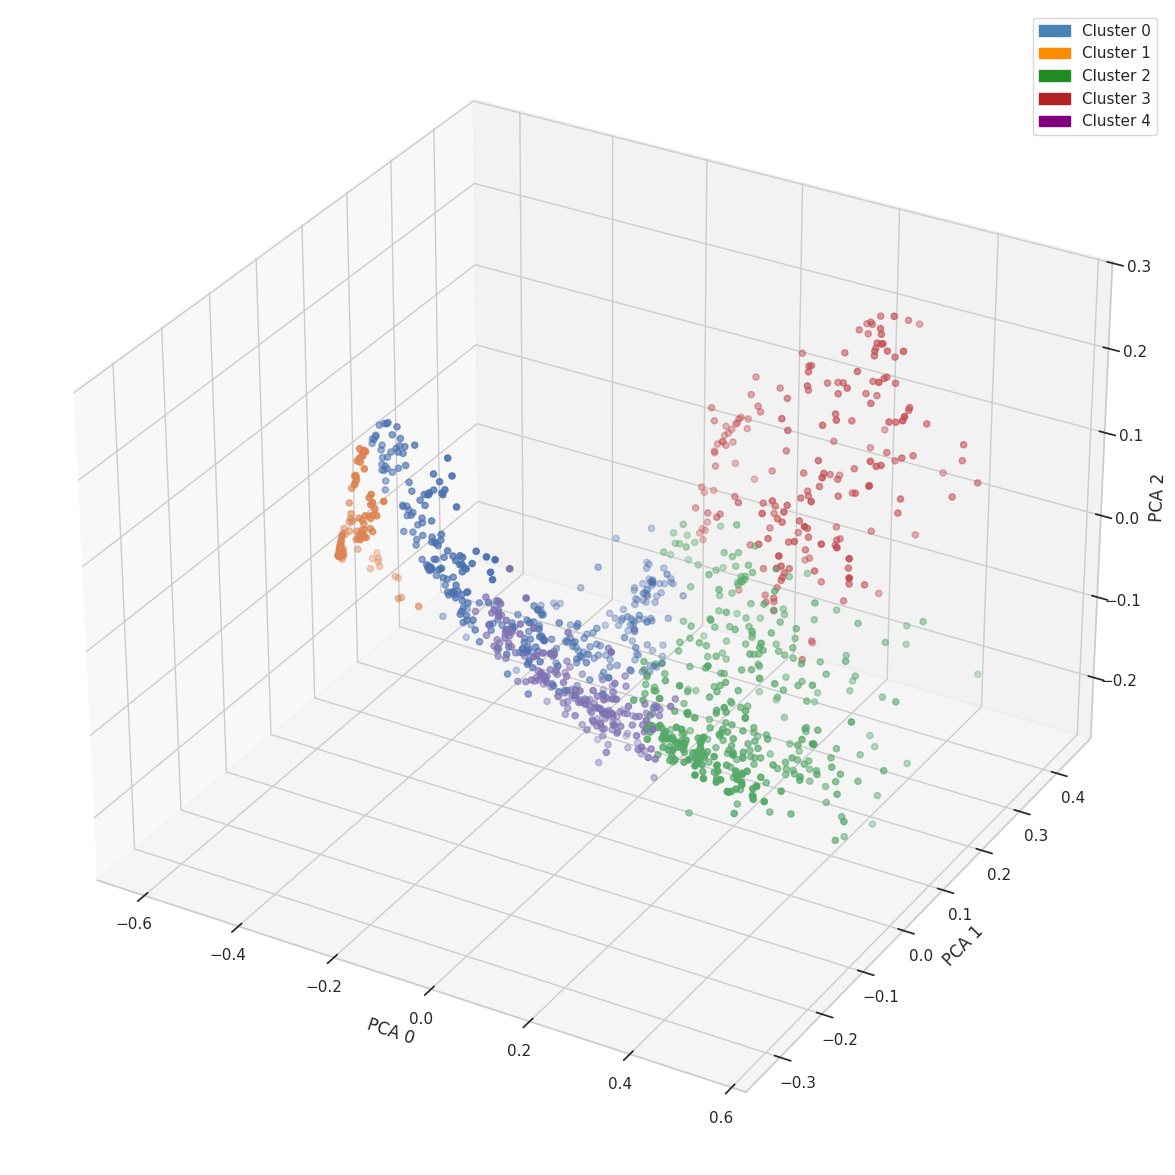

In [27]:
## 3D representation of encoded data, colour coded by clustering of 9D data

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(np.array(encoded_imgs_3d_0)[:,0],np.array(encoded_imgs_3d_0)[:,1],np.array(encoded_imgs_3d_0)[:,2])
ax.scatter(np.array(encoded_imgs_3d_1)[:,0],np.array(encoded_imgs_3d_1)[:,1],np.array(encoded_imgs_3d_1)[:,2])
ax.scatter(np.array(encoded_imgs_3d_2)[:,0],np.array(encoded_imgs_3d_2)[:,1],np.array(encoded_imgs_3d_2)[:,2])
ax.scatter(np.array(encoded_imgs_3d_3)[:,0],np.array(encoded_imgs_3d_3)[:,1],np.array(encoded_imgs_3d_3)[:,2])
ax.scatter(np.array(encoded_imgs_3d_4)[:,0],np.array(encoded_imgs_3d_4)[:,1],np.array(encoded_imgs_3d_4)[:,2])

blue = mpatches.Patch(color=palette[0], label='Cluster 0')
orange = mpatches.Patch(color=palette[1], label='Cluster 1')
green = mpatches.Patch(color=palette[2], label='Cluster 2')
red = mpatches.Patch(color=palette[3], label='Cluster 3')
purple = mpatches.Patch(color=palette[4], label='Cluster 4')

ax.set_xlabel('PCA 0')
ax.set_ylabel('PCA 1')
ax.set_zlabel('PCA 2')
plt.legend(handles=[blue,orange,green,red,purple])


In [28]:
# average temperature distribution for each cluster

e_temp_0 = []
e_temp_1 = []
e_temp_2 = []
e_temp_3 = []
e_temp_4 = []

for i in range(len(ac_clustering_9)):
    if ac_clustering_9[i] == 0:
        e_temp_0.append(e_temp[i])
    if ac_clustering_9[i] == 1:
        e_temp_1.append(e_temp[i])
    if ac_clustering_9[i] == 2:
        e_temp_2.append(e_temp[i])
    if ac_clustering_9[i] == 3:
        e_temp_3.append(e_temp[i])
    if ac_clustering_9[i] == 4:
        e_temp_4.append(e_temp[i])

e_temp_0_mean = np.mean(e_temp_0[:],axis=0)
e_temp_1_mean = np.mean(e_temp_1[:],axis=0)
e_temp_2_mean = np.mean(e_temp_2[:],axis=0)
e_temp_3_mean = np.mean(e_temp_3[:],axis=0)
e_temp_4_mean = np.mean(e_temp_4[:],axis=0)
e_temp_means = (e_temp_0_mean,e_temp_1_mean,e_temp_2_mean,e_temp_3_mean,e_temp_4_mean)


In [29]:
# average density distribution for each cluster

e_density_0 = []
e_density_1 = []
e_density_2 = []
e_density_3 = []
e_density_4 = []

for i in range(len(ac_clustering_9)):
    if ac_clustering_9[i] == 0:
        e_density_0.append(e_density[i])
    if ac_clustering_9[i] == 1:
        e_density_1.append(e_density[i])
    if ac_clustering_9[i] == 2:
        e_density_2.append(e_density[i])
    if ac_clustering_9[i] == 3:
        e_density_3.append(e_density[i])
    if ac_clustering_9[i] == 4:
        e_density_4.append(e_density[i])

e_density_0_mean = np.mean(e_density_0[:],axis=0)
e_density_1_mean = np.mean(e_density_1[:],axis=0)
e_density_2_mean = np.mean(e_density_2[:],axis=0)
e_density_3_mean = np.mean(e_density_3[:],axis=0)
e_density_4_mean = np.mean(e_density_4[:],axis=0)
e_density_means = (e_density_0_mean,e_density_1_mean,e_density_2_mean,e_density_3_mean,e_density_4_mean)


In [30]:
print(np.min(e_temp_means[:]), np.max(e_temp_means[:]))
print(np.min(e_density_means[:]), np.max(e_density_means[:]))

0.0 1149.9240707968645
0.0 4.431879409349314e+19


Cluster 0: 352 shots


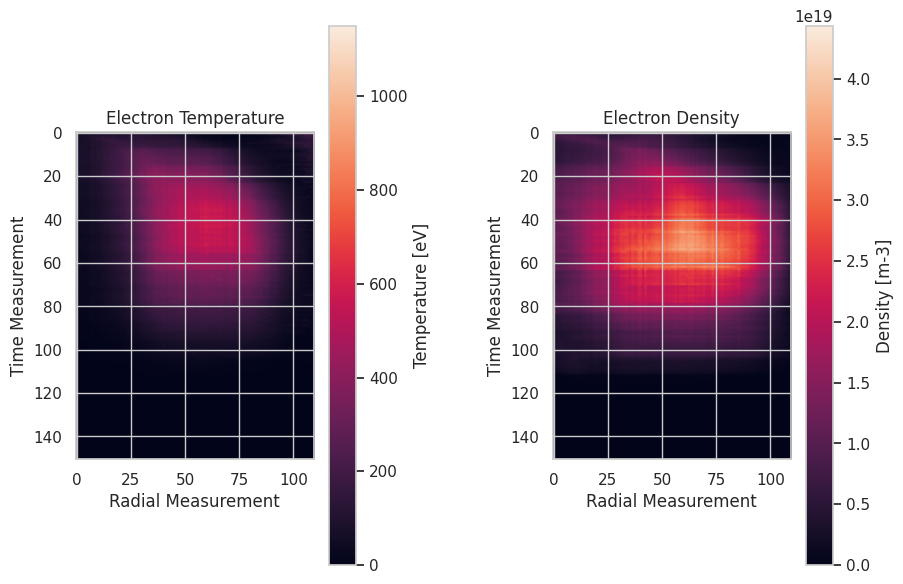

Cluster 1: 260 shots


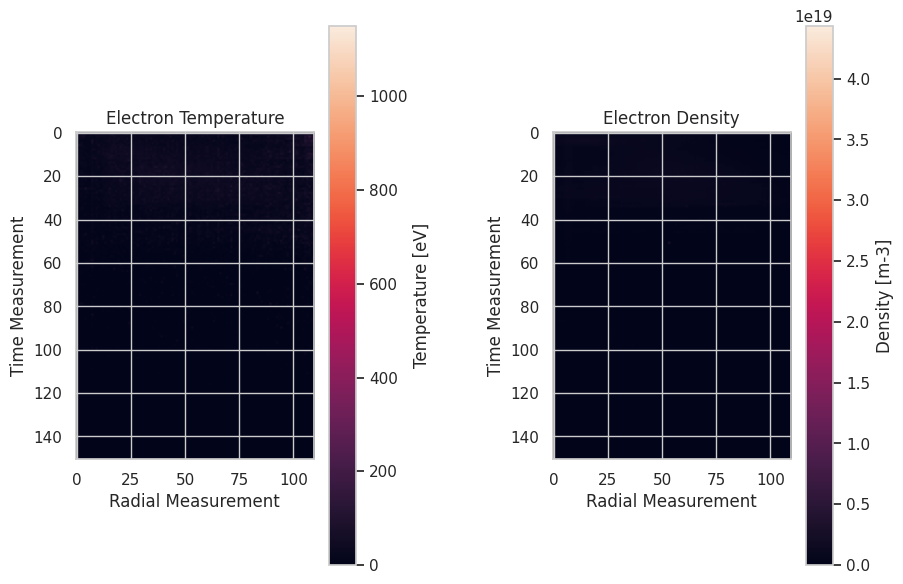

Cluster 2: 374 shots


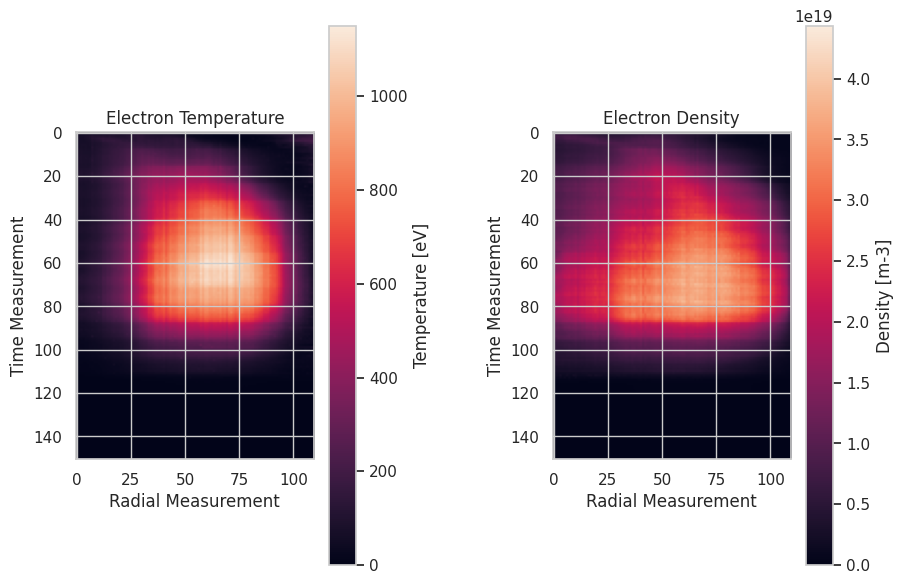

Cluster 3: 191 shots


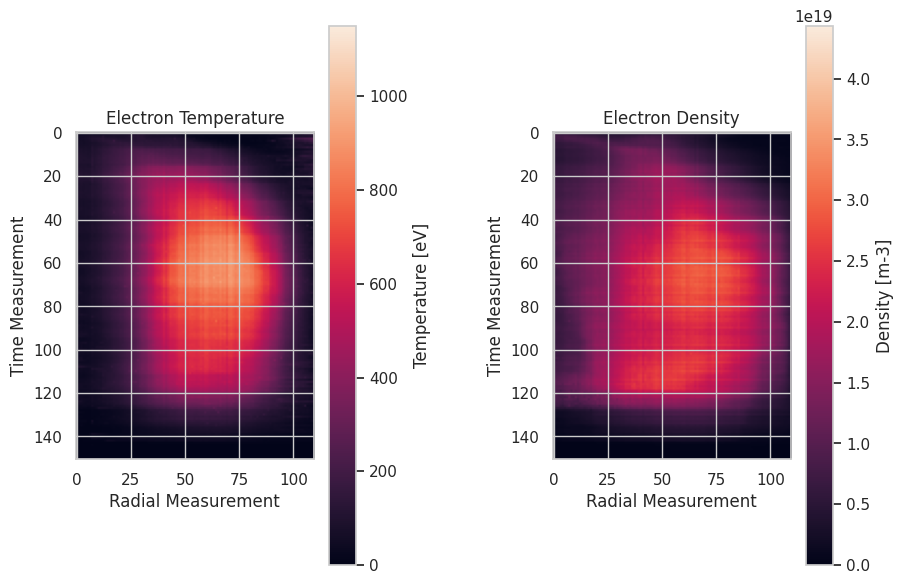

Cluster 4: 189 shots


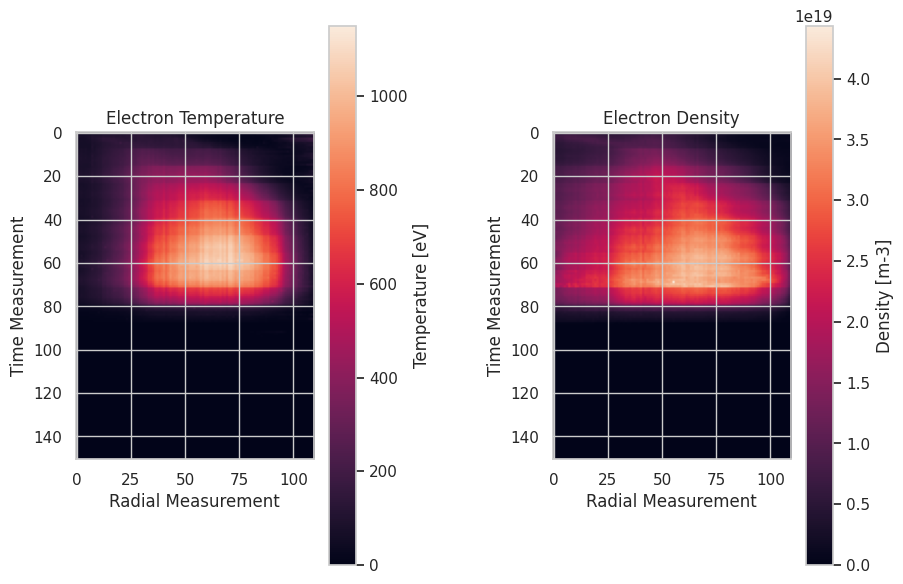

In [31]:
## plot average temp and density shot distribution for each cluster

for i in range(len(e_temp_means)):
    print('Cluster '+str(i)+': '+str(Counter(ac_clustering_9)[i])+' shots')

    fig = plt.figure(figsize=(10,7))
    fig.add_subplot(1,2,1)
    plt.imshow((e_temp_means[i]), vmin=0, vmax=(np.max(e_temp_means[:])))
    plt.title('Electron Temperature')
    plt.xlabel('Radial Measurement')
    plt.ylabel('Time Measurement')
    plt.colorbar(label='Temperature [eV]')

    fig.add_subplot(1,2,2)
    plt.imshow(e_density_means[i], vmin=0, vmax=np.max(e_density_means[:]))
    plt.title('Electron Density')
    plt.xlabel('Radial Measurement')
    plt.ylabel('Time Measurement')
    plt.colorbar(label='Density [m-3]')

    plt.subplots_adjust(wspace=0.6)
    plt.show()

### Analysis of time-series clusters

In [32]:
## reshape temp and density for scatter graphs

new_e_temp = e_temp.reshape(len(e_temp),-1)
new_e_density = e_density.reshape(len(e_density),-1)
np.shape(np.mean(new_e_temp,axis=1))

df_time_series = pd.DataFrame({'clusters':ac_clustering_9})

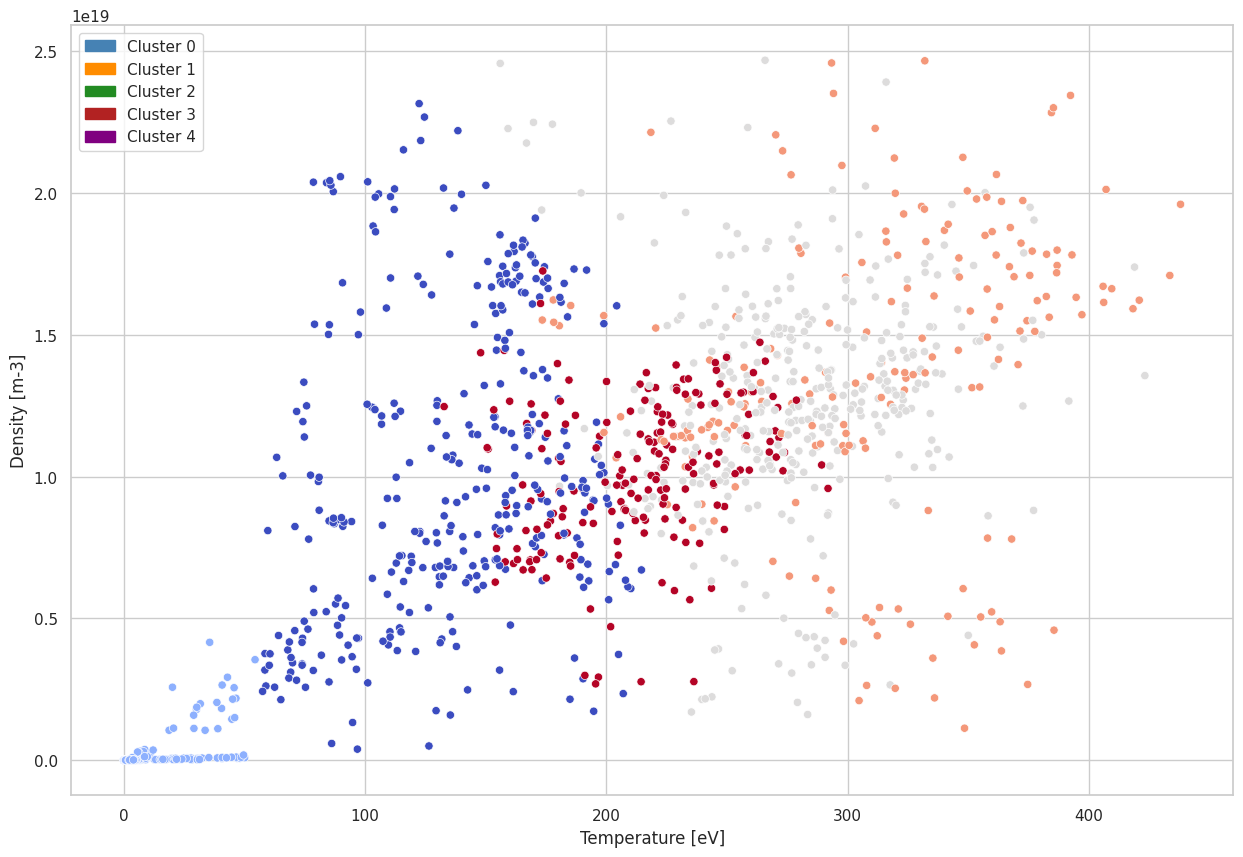

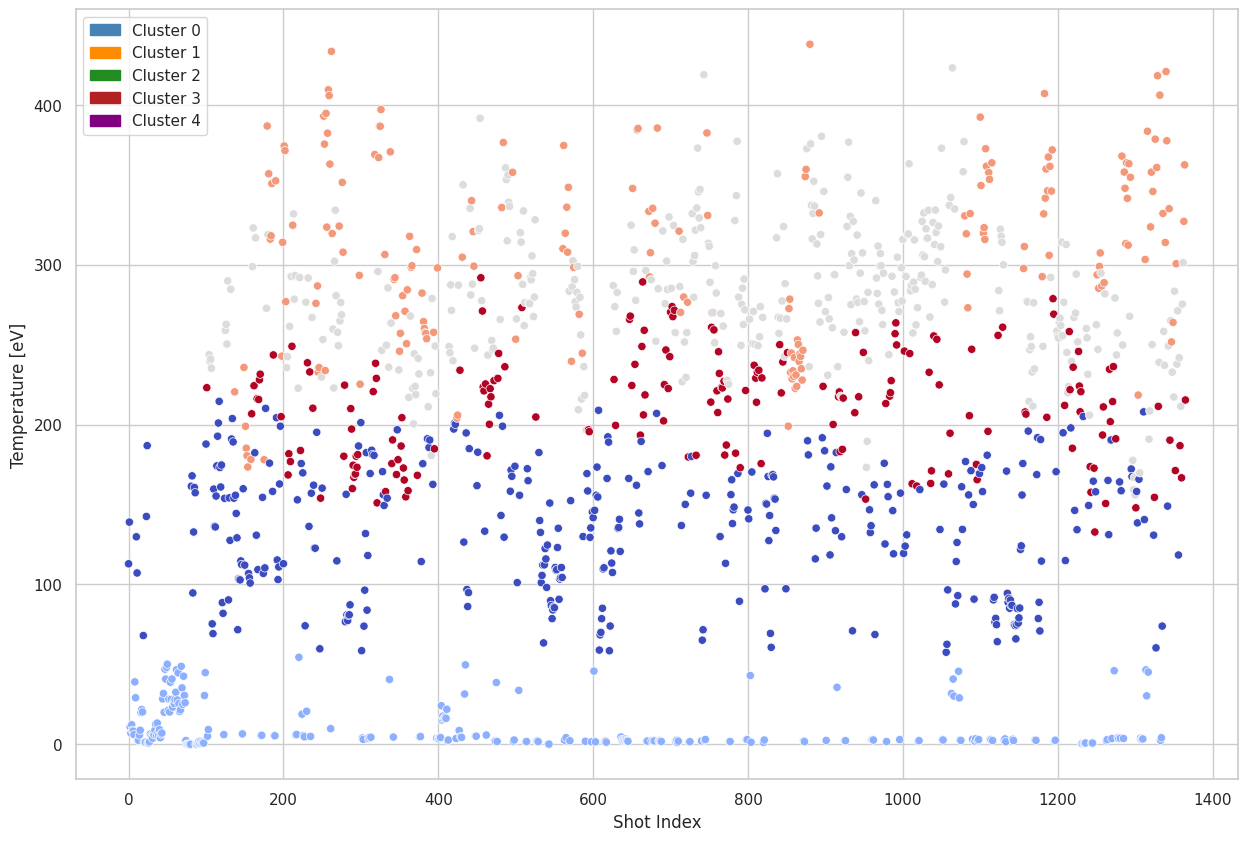

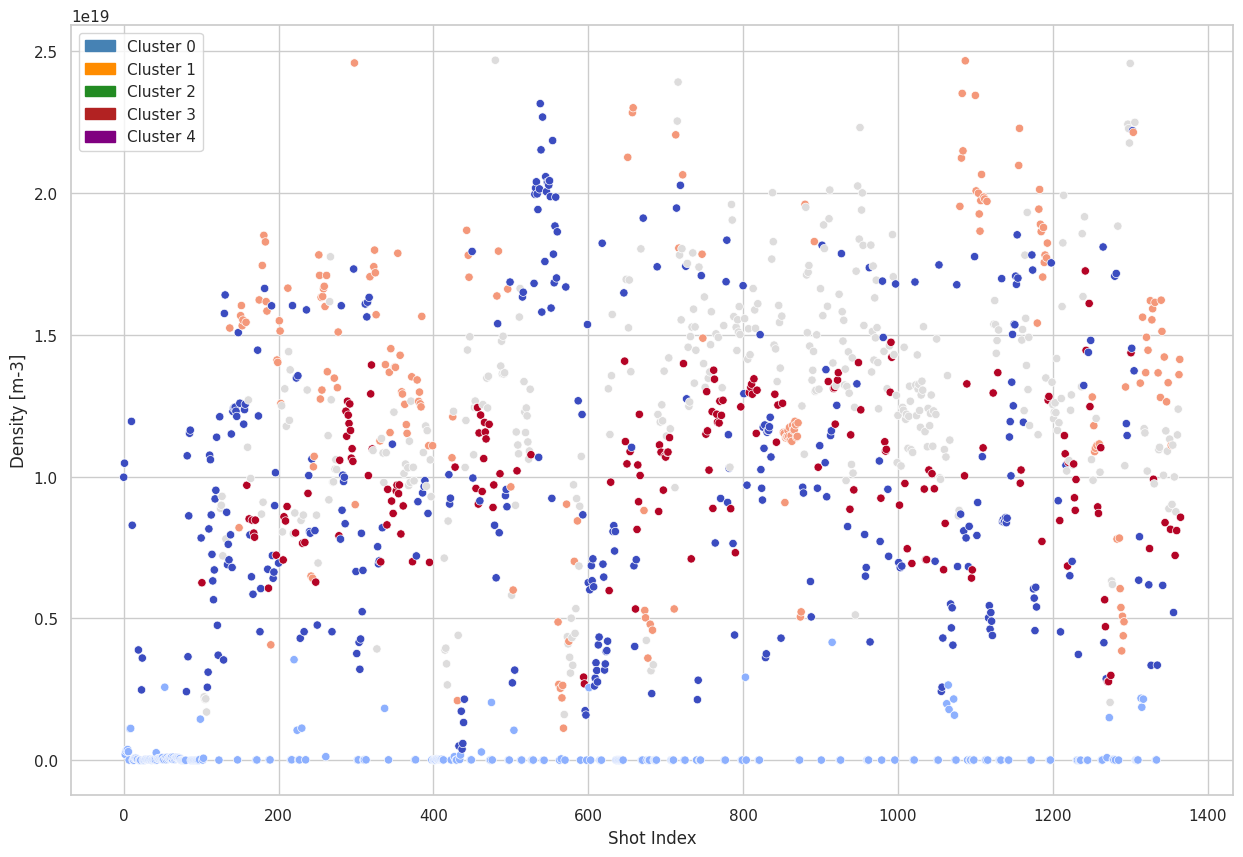

In [33]:
## time-series clustering scatter graphs

## mean temp vs mean density
plt.figure(figsize=(15,10))
ax = sns.scatterplot(x=np.mean(new_e_temp,axis=1), y=np.mean(new_e_density,axis=1), data=df_time_series, hue='clusters',palette=sns.color_palette('coolwarm', as_cmap = True),legend=False)
ax.set(xlabel='Temperature [eV]',ylabel='Density [m-3]')
plt.legend(handles=[blue,orange,green,red,purple],loc='upper left')
plt.show()

## mean temp
plt.figure(figsize=(15,10))
ax = sns.scatterplot(x=df_time_series.index, y=np.mean(new_e_temp,axis=1), data=df_time_series, hue='clusters',palette=sns.color_palette('coolwarm', as_cmap = True),legend=False)
ax.set(xlabel='Shot Index',ylabel='Temperature [eV]')
plt.legend(handles=[blue,orange,green,red,purple],loc='upper left')
plt.show()

## mean density
plt.figure(figsize=(15,10))
ax = sns.scatterplot(x=df_time_series.index, y=np.mean(new_e_density,axis=1), data=df_time_series, hue='clusters',palette=sns.color_palette('coolwarm', as_cmap = True),legend=False)
ax.set(xlabel='Shot Index',ylabel='Density [m-3]')
plt.legend(handles=[blue,orange,green,red,purple],loc='upper left')
plt.show()

---

# 4. Exercise

### Dynamic Time Warping (DTW) time-series Clustering

* Cluster time series data using clustering methods in scikit learn with DTWDistance given below:

In [34]:
def DTWDistance(s1, s2):
    DTW={}

    for i in range(len(s1)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(s2)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(len(s2)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return np.sqrt(DTW[len(s1)-1, len(s2)-1])